In [1]:
import pymc as pm
import numpy as np
from scipy import stats

import aesara.tensor as at

import os
from utility import *
from utility_data_deal import *

In [4]:
data_index_factor,data_index,data_factor= import_index_factor()
data_factor_adj,data_index_factor_adj=orthogonalized_factors(data_index_factor,data_index.name,data_factor.columns.to_list())
[IR_mean,IR_sample_mean,IR_sample_std]=Bootstrap_mean_std_IR(data_index_factor_adj)
data_index_factor_adj.index=data_index_factor_adj.index.to_period("M")

#########市场指数

dic_Style_fund,dic_fund_Style=fund_file2dic()
data_alpha=query_alpha_fund_type_data("大盘价值")
data_alpha.index= data_alpha.index.to_period("M")

######宏观指数
from load_macro import DB_new_interpolate
data = pd.DataFrame(DB_new_interpolate).ffill().iloc[:,[1,2,3]].dropna()
data.index=data.index.to_period("M")





#########


df_data = pd.DataFrame(columns = ["Period"]).set_index("Period")
date =pd.date_range(start="2010-02-01",end="2022-06-01",freq="M").to_period("M")
df_data.index=date
df_data["Test_"] = "True"
df_macro_filter = pd.concat([df_data,data],axis=1).query('Test_=="True"')

df_Factor_filter=pd.concat([df_data,data_index_factor_adj],axis=1).query('Test_=="True"')
data_alpha_filter =pd.concat([df_data,data_alpha],axis=1).query('Test_=="True"')
data_total =pd.concat([df_Factor_filter.drop("Test_",axis=1),data_alpha_filter.drop("Test_",axis=1)],axis=1).T



########DF_data
Df_alpha=data_alpha_filter.drop("Test_",axis=1).T
Df_macro = df_macro_filter.drop("Test_",axis=1).T
Df_Factor=df_Factor_filter.drop("Test_",axis=1).T

prior_mu = np.array([x for x in IR_mean])
prior_std = np.array([x for x in IR_sample_std])


In [5]:

coords = {"Fund": Df_Factor.index.values, "date":data_total.columns.to_timestamp().date,"macro":Df_macro.index.values,"Alpha":Df_alpha.index.values}

with pm.Model(coords=coords) as model12:
   #   sharpe_ratio= pm.Normal("μ", prior_mu.T, prior_std)
#     sharpe_ratio=at.reshape(sharpe_ratio,(6,1))
#     beta = pm.Normal("beta", mu=0, sigma=20,shape=(6,3))
     
#     data_macro = pm.Data("data", Df_macro.values.astype(float),mutable=True)


#     sharpe_ratio_t = pm.Deterministic("SR_t",at.tile(sharpe_ratio,(1,148)) + at.dot(beta,data_macro))


#     sd_dist=pm.Exponential("std",1.0,shape=1)
#     #sd_dist=at.reshape(sd_dist,(6,1))
#    # sd_T =at.tile(sd_dist,(1,148)) 

#     obs = pm.Normal("obs",mu=sharpe_ratio_t*sd_dist,sigma=sd_dist,observed=Df_Factor.values)
    
    sharpe_ratio= pm.Normal("μ", prior_mu.T, prior_std, dims=("Fund"))
    sharpe_ratio=at.reshape(sharpe_ratio,(6,1))
    beta = pm.Normal("beta", mu=0, sigma=20,shape=(6,3),dims=("Fund","macro"))
    data_macro = pm.Data("data", Df_macro.values.astype(float),mutable=True,dims=("macro","date"))
    sharpe_ratio_t = pm.Deterministic("SR_t",at.tile(sharpe_ratio,(1,148)) + at.dot(beta,data_macro),dims=("Fund","date"))
    #sd_dist=pm.Exponential("std",1.0,shape=6,dims=("Fund"))
    sd_dist=pm.Exponential("std",1.0,shape=6,dims=("Fund"))
    sd_dist= at.reshape(sd_dist,(6,1))
    sd_T =at.tile(sd_dist,(1,148)) 
    obs = pm.Normal("obs",mu=sharpe_ratio_t*sd_dist,sigma=sd_dist,observed=Df_Factor,dims=("Fund", "date"))

    
    
    
    
    
    
    
    

In [117]:

                               
   # sharpe_ratio_t = 
                               
    #i_alpha =T.dot(SR[:-1],coe)+SR[-1]
                               
                               
     #factor_loading = pm.Normal("factor_loading", mu=0, sigma=20,shape=,dims=("Fund")

In [103]:
alpha_mean__prior =2
alpha_std__prior =0.17
LKJ_eta__prior =3
LKJ_st_prior =1.0

T_len=148

__Df_alpha_model=Df_alpha.iloc[:15,:]
alpha_len = __Df_alpha_model.shape[0]
coords_test = {"Fund": Df_Factor.index.values, "date":data_total.columns.to_timestamp().date,"macro":Df_macro.index.values,"Alpha":Df_alpha_model.index.values}

with pm.Model(coords=coords_test) as model_test:
    _data_alpha_fund = pm.Data("data_alpha_fund", __Df_alpha_model.values.astype(float),mutable=True,dims=("Alpha","date"))
    alpha = pm.Normal("μ_alpha",alpha_mean__prior, alpha_std__prior)
    alpha_n = pm.Normal("IC_alpha",alpha,sigma=1,shape=alpha_len,dims=("Alpha"))
    alpha_n= at.reshape(alpha_n,(alpha_len,1))
    IC_alpha_t = pm.Deterministic("SR_alpha_t",at.tile(alpha_n,(1,148)),dims=("Alpha","date"))
        
    chol, corr, stds = pm.LKJCholeskyCov(
    "chol", n=alpha_len, eta=LKJ_eta__prior, sd_dist=pm.Exponential.dist(LKJ_st_prior), compute_corr=True
    )



    #alpha_n_cov = pm.Deterministic("cov", chol.dot(chol.T))     
    
    T_n_cov =np.eye(T_len)
    
    obs=pm.MatrixNormal('vals', mu=IC_alpha_t, rowchol=chol,colcov=T_n_cov)
    
    __Df_alpha_fit_data_model=__Df_alpha_model.values[~np.isnan(__Df_alpha_model.values)]
    alpha_fit_variable = obs[~np.isnan(__Df_alpha_model.values)]
    obss=pm.Normal("_IC",alpha_fit_variable,sigma=0.00001,observed=__Df_alpha_fit_data_model)
  
    #obs = pm.MvNormal("obs_alpha",mu=IC_alpha_t,sigma=at.tile(cov,(1,148),observed=Df_alpha,dims=("alpha", "date"))
RANDOM_SEED = 8924
with model_test:
    trace_alpha = pm.sample(draws=500,random_seed=RANDOM_SEED, init="advi",chains=1,n_init=500, tune=500,target_accept=0.8,return_inferencedata=True)
  
    

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Finished [100%]: Average Loss = 3.3177e+13
Sequential sampling (1 chains in 1 job)
NUTS: [μ_alpha, IC_alpha, chol, vals]


Sampling 1 chain for 500 tune and 500 draw iterations (500 + 500 draws total) took 4533 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

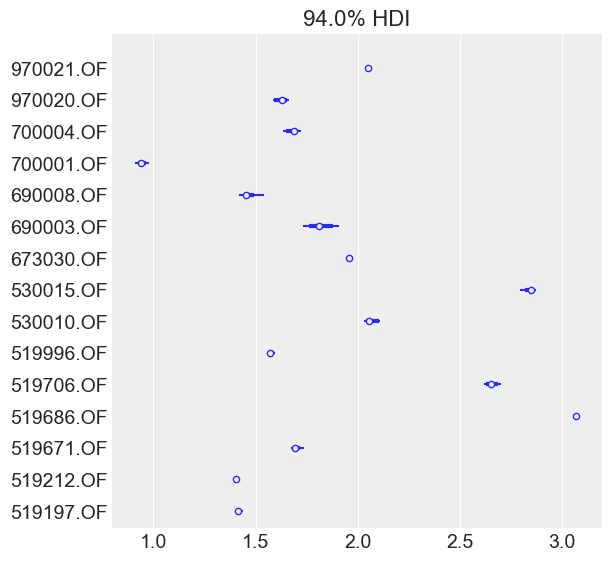

In [109]:
 az.plot_forest(
    trace_alpha,
    var_names=["IC_alpha"],
    combined=True,
    coords={"Alpha":Df_alpha_model.index.values},
    labeller=az.labels.NoVarLabeller(),
)


In [84]:
Df_alpha_model=Df_alpha.iloc[:15,:]

In [85]:
Df_alpha_model.shape[0]

15

In [69]:
alpha_n_cov.eval()[0:2,0:2]

array([[0.76391519, 0.07565692],
       [0.07565692, 5.4618539 ]])

<AxesSubplot: title={'center': 'μ_alpha'}>

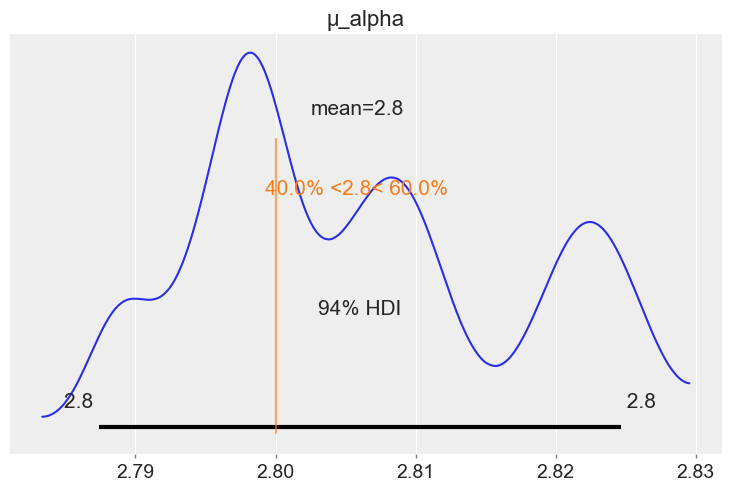

In [114]:
az.plot_posterior(trace_alpha, var_names=["μ_alpha"],ref_val=2.8)

In [ ]:
fig,ax =plt.subplots(6,1,figsize=(10,20))
for i in range(6):
    ax[i].plot(_xx+2010,trace.posterior.stack(pooled_chain=("chain", "draw"))["SR_alpha_t"].mean(axis=2)[i],label=Df_Factor.index.values[i])
    ax[i].legend()